# Analysis of Ronchi Grating
This code is for prototyping the investigation of the resolution of the OPT system using a grating.

1. Imports image stack of grating, perform averaging operation
2. Investigates whether there is rotational misalignment of the grating
3. Finds in-focus grating image
4. Takes 2D FFT
5. Analyses the frequency component
   1. Uses central spectrum of FFT to find harmonic peaks
6. Defines ideal Ronchi grating function
7. MTF Extraction



In [121]:
import skimage
from skimage import io
import matplotlib.pyplot as plt

from scipy.fft import fft, fft2,fftshift, fftfreq
import numpy as np
import scipy as sp
import pandas as pd

Loads image of Ronchi grating in.

In [200]:
# PATH_TO_IMAGE =  '../../OPT Shared files/2022-10-31 dof contd/aperture/2022-10-31-f6 depth sweep wide range stack/MMStack_Pos0.ome.tif'
PATH_TO_IMAGE =  '../../OPT Shared files/1_Data/2023-01-17 grating redone/2023-01-17 grating in water f-c/MMStack_Pos0.ome.tif'
im_stack = io.imread(PATH_TO_IMAGE)

In [201]:
im_stack.shape

(125, 1392, 1040)

In [202]:
def get_averaged_stack(im_stack, num_repeats):
    # Gets averaged image stack, assuming shape of image stack is (num_repeats * z_stack_depth, im_height, im_width)
    # num_repeats (int): number of averaged images
    num_repeats = int(num_repeats)

    dim_0, im_length, im_width = im_stack.shape
    reshaped = im_stack.reshape(dim_0//num_repeats, num_repeats, im_length, im_width)
    output = np.mean(reshaped, axis=1)
    return output
    
num_repeats = 5

Investigation of Variance

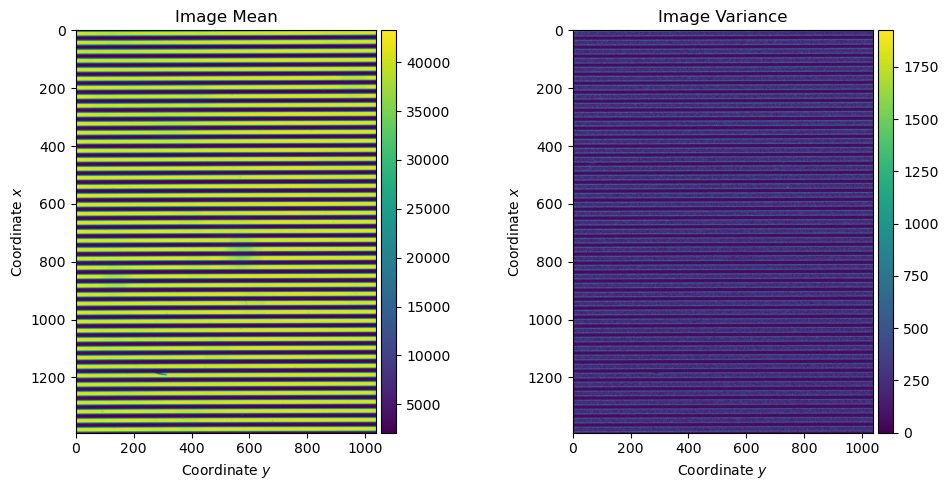

In [203]:
# Compute pixel-wise variance
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Manually reshape array
dim_0, im_length, im_width = im_stack.shape
reshaped = im_stack.reshape(dim_0//num_repeats, num_repeats, im_length, im_width)

im_mean = np.mean(reshaped[14], axis=0)
im_std = np.std(reshaped[14], axis=0)

# Plot images
fig, ax = plt.subplots(1,2, figsize=(10,5))
im_0 = ax[0].imshow(im_mean)
im_1 = ax[1].imshow(im_std)
# fig.colorbar(im_0)

# Set colourbars for the two images
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im_0, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im_1, cax=cax, orientation='vertical')

# Label the axes
ax[0].set_title('Image Mean')
ax[0].set_ylabel('Coordinate $x$')
ax[0].set_xlabel('Coordinate $y$')
ax[1].set_title('Image Variance')
ax[1].set_ylabel('Coordinate $x$')
ax[1].set_xlabel('Coordinate $y$')
plt.tight_layout()

In [204]:
im_stack = get_averaged_stack(im_stack, num_repeats)

## Correct for tilt

In [205]:
tilt = -0.18 #degrees
rotated = sp.ndimage.rotate(im_stack, axes = (1,2), angle=tilt, reshape=False, order=3)
im_stack = rotated

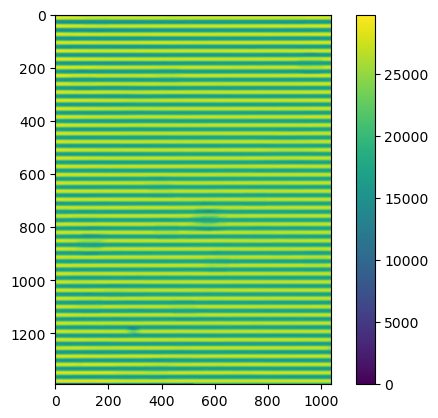

In [206]:
plt.imshow(rotated[0])
plt.colorbar()

Find in-focus frame. The frame in focus is likely the one with the maximum and minimum brightness.

In [207]:
np.unravel_index(np.argmax(im_stack), im_stack.shape), np.unravel_index(np.argmin(im_stack), im_stack.shape)

((13, 383, 1037), (0, 0, 0))

/Users/kenton/opt/anaconda3/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


Text(0.5, 0, 'Coordinate $y$')

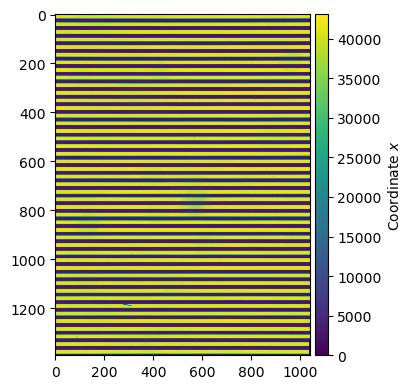

In [208]:
im = im_stack[12]
plt.figure(figsize=(4,4))
io.imshow(im)
plt.ylabel('Coordinate $x$')
plt.xlabel('Coordinate $y$')

### Rotational Misalignment Investigation

Text(0.5, 0, 'Pixel coordinate')

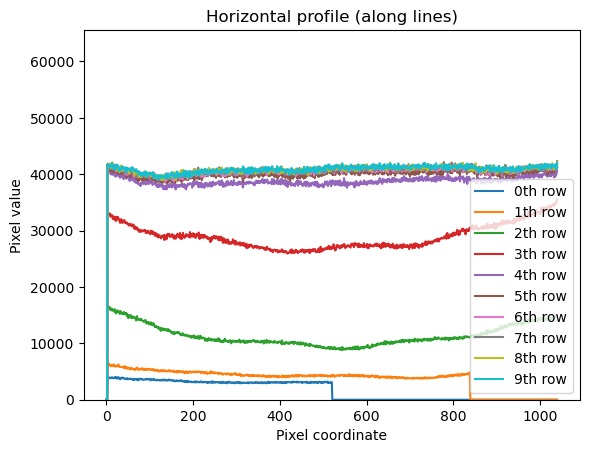

In [209]:
for i in range(0, 10, 1):
    plt.plot(im[i], label=f'{i}th row')

# plt.plot(im[1])
plt.ylim(0,65565)
plt.title('Horizontal profile (along lines)')
plt.ylabel('Pixel value')
plt.legend()
plt.xlabel('Pixel coordinate')

An example line profile, no cropping used.

(0.0, 50.0)

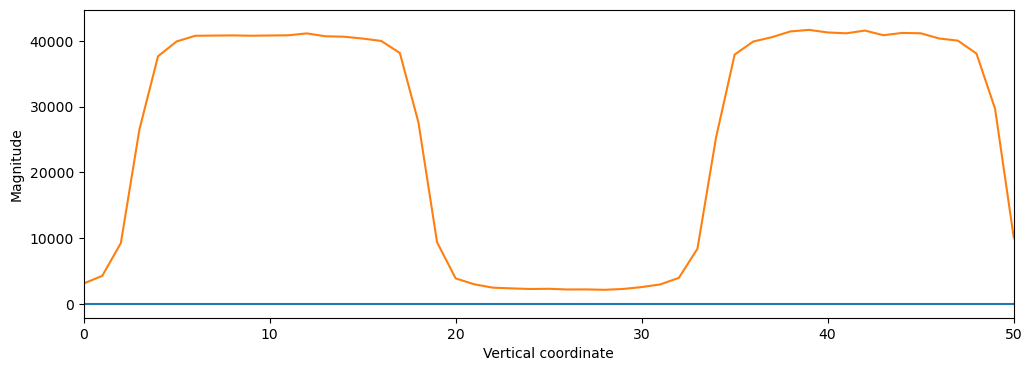

In [210]:
plt.figure(figsize=(12,4))
plt.ylabel('Magnitude')
plt.xlabel('Vertical coordinate')
plt.plot(im[:,0])
plt.plot(im[:,500])
plt.xlim(0,50)

**Unit conversions**

Line pair / mm refers to a frequency unit, which is equivalent to cycles per mm.

We know that 1 pixel has size $e = 6.45 \ \mu m$. Thus 1 pixel represents $l = e/m$ in object space where $m$ is the lens magnification.

The highest frequency that can be sampled is $k = \frac{1}{2l} = \frac{m}{2e}$.

In [211]:
e = 6.45/ 1000 # pixel size (mm)
# m = 0.5
m = 1.0
length_per_pixel = e/m

Text(0.5, 0, 'Horizontal spatial frequency (lp mm$^{-1}$)')

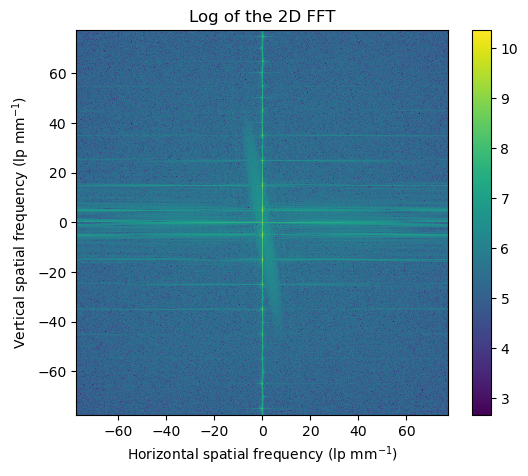

In [212]:
# Take FFT
ft = fftshift(fft2(im[200:1200]))

x_size = ft.shape[0]
y_size = ft.shape[1]

# multiply by 2 to get units in line pairs per mm
x_freqs = fftshift(fftfreq(x_size, d = length_per_pixel)) 
y_freqs = fftshift(fftfreq(y_size, d = length_per_pixel) )


ft_log = np.log10(np.abs(ft))
X,Y = np.meshgrid(x_freqs, y_freqs)
plt.figure(figsize=(6,5))
plt.title('Log of the 2D FFT')
plt.pcolormesh(Y, X, ft_log.T, shading='auto')
plt.colorbar()
plt.ylabel('Vertical spatial frequency (lp mm$^{-1}$)')
plt.xlabel('Horizontal spatial frequency (lp mm$^{-1}$)')

In [213]:
# plt.title('Plot of the FFT (Horizontal slice)')
# plt.plot(x_freqs, (np.abs(ft)[:,0])/np.max(np.abs(ft)), ls='-')
# plt.xlabel('Frequencies (line pairs per mm)')

Extract peaks from the Fourier Transform

In [214]:
peaks_threshold = 0.001
fundamental_threshhold = 0.2 
rtol = 0.02

In [215]:
# Absolute value of the Fourier transform, normalised by its maximum
ft_slice = (np.abs(ft)[:,y_size//2])/np.max(np.abs(ft))
peaks, _ = sp.signal.find_peaks(ft_slice, height=peaks_threshold)

# Extract fundamental frequency 
fundamental_peak, _ = sp.signal.find_peaks(ft_slice, height=fundamental_threshhold)
fundamental_peak = fundamental_peak[-1]
base_frequency = x_freqs[fundamental_peak] 

selected_freqs = x_freqs[peaks]/base_frequency

# Filter out unwanted frequencies

# Define function to find peaks near harmonic frequencies
# Determine maximum harmonic using Nyquist frequency divided by base freq
harmonics = np.append(0, np.arange(1, x_freqs[-1]/base_frequency, 2, dtype=int))

def find_matches(input, match, rtol,):
    # Returns binary array with length of (input) where input is close to any
    # element of match with tolerance rtol

    output = np.zeros(len(input), dtype=bool)
    for i, input_value in enumerate(np.abs(input)):
        out = False
        for num in match:
            # When close to limits rtol, set binary array value to be True
            out = out or np.isclose(input_value, num, rtol=rtol)
        output[i] = bool(out)
    return output

peaks = peaks[find_matches(selected_freqs, harmonics, rtol)]

Text(0.5, 1.0, 'Plot of the FFT (Vertical slice)')

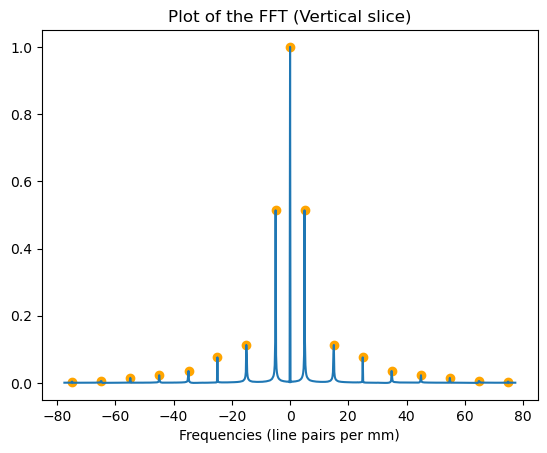

In [216]:
def plot_slice_with_peaks(x_freqs, ft_slice, peaks):
    plt.plot(x_freqs, ft_slice, ls='-')
    plt.scatter(x_freqs[peaks], ft_slice[peaks], c='orange')
    plt.xlabel('Frequencies (line pairs per mm)')
    return
    
plot_slice_with_peaks(x_freqs, ft_slice, peaks)
plt.title('Plot of the FFT (Vertical slice)')
# plt.xlim(34,36)
# plt.ylim(0, 0.01)

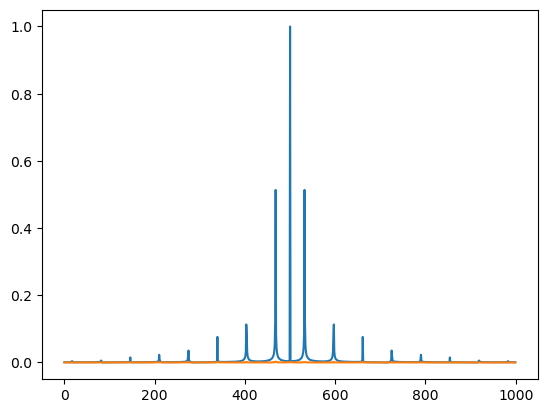

In [217]:
plt.plot((np.abs(ft)[:,y_size//2])/np.max(np.abs(ft)))
plt.plot((np.abs(ft)[:,y_size//2-1])/np.max(np.abs(ft)))

## Extraction of the MTF

### Defining your grating function

We need to define two things: the value of the central harmonic and the value of the first harmonic.

One way would be to use the maximum and minimum values of the whole dataset to set the 'ideal' grating.

Text(0.5, 0, 'Frequencies (line pairs per mm)')

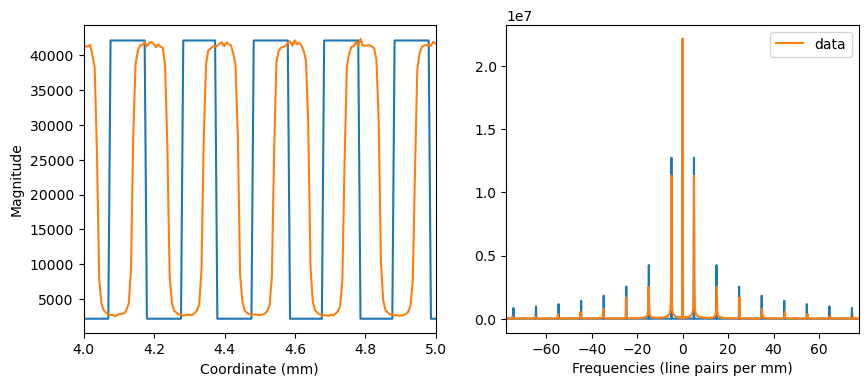

In [218]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

# Apply cropping
line = im[200:1200,500]
t = np.arange(0, len(line))
offset = np.average(line)
scale = (np.max(line) - np.min(line))/2 # Original case : to use the max - min /2 as the first harmonic
# scale = offset*ft_slice[peaks][len(peaks)//2 +1 ] * np.pi/2   # New case: use first harmonic 
wave = scale* sp.signal.square(2*np.pi* base_frequency*length_per_pixel * (t-7)) + offset

# Plot length domain
ax[0].plot(t*length_per_pixel, wave)
ax[0].plot(t*length_per_pixel, line)
# ax[0].plot(t*length_per_pixel,large_wave)
ax[0].set_ylabel('Magnitude')
ax[0].set_xlabel('Coordinate (mm)')
ax[0].set_xlim(4,5)

# Generate fully sampled square wave to reduce parasitic frequency effects
sampling_factor = 16
new_t = np.arange(0, len(line),1/sampling_factor)
wave_fft = fftshift(fft(scale* sp.signal.square(2*np.pi* base_frequency*length_per_pixel * (new_t-7))+ offset))/sampling_factor
new_sample_freq = fftshift(fftfreq(len(wave_fft), d = length_per_pixel/sampling_factor))

ax[1].plot(new_sample_freq, np.abs(wave_fft))
ax[1].plot(fftshift(fftfreq(len(wave), d = length_per_pixel)), np.abs(fftshift(fft(line))), label='data')
ax[1].set_xlim(x_freqs[0], x_freqs[-1])
ax[1].legend()
ax[1].set_xlabel('Frequencies (line pairs per mm)')


When the ideal grating function is manually fitted, we can extract its peaks.

Text(0.5, 1.0, 'FT of ideal grating function')

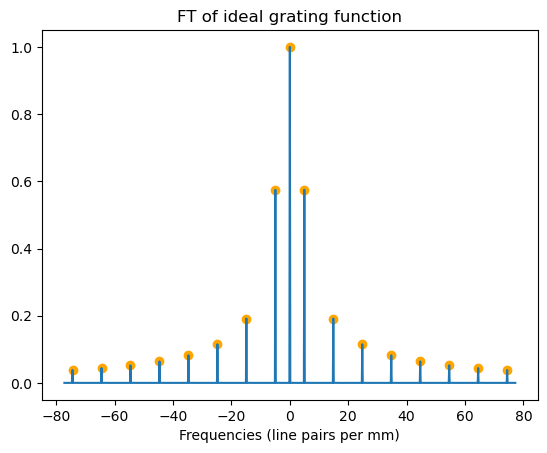

In [219]:
offset_height = np.max(np.abs(wave_fft))

# Normalised datasets are divided by offset_height
# also filter the lengthened fft to sample line lengths

crit = np.abs(new_sample_freq)< np.max(fftshift(fftfreq(len(wave), d = length_per_pixel)))
norm_wave_fft = wave_fft[crit]/ offset_height
norm_data  = np.abs(fftshift(fft(line)))/offset_height
simulated_fft_peaks, _ = sp.signal.find_peaks(np.abs(norm_wave_fft), threshold=0.001)

plot_slice_with_peaks(new_sample_freq[crit], np.abs(norm_wave_fft), simulated_fft_peaks)
plt.title('FT of ideal grating function')

Extract harmonic heights and place in DataFrame.

In [220]:
df = pd.DataFrame.from_dict({'harmonics': harmonics, 'simulated_fft_height':np.abs(norm_wave_fft)[simulated_fft_peaks][-len(harmonics):]})
df

,harmonics,simulated_fft_height
0,0,1.000000
1,1,0.574866
2,3,0.191628
3,5,0.114985
4,7,0.082140
5,9,0.063895
6,11,0.052287
7,13,0.044252
8,15,0.038360


Try on alternative. Peaks quite sensitive to threshold.

Are the correct number of peaks picked out? False


Text(0.5, 1.0, 'FFT of Image slice')

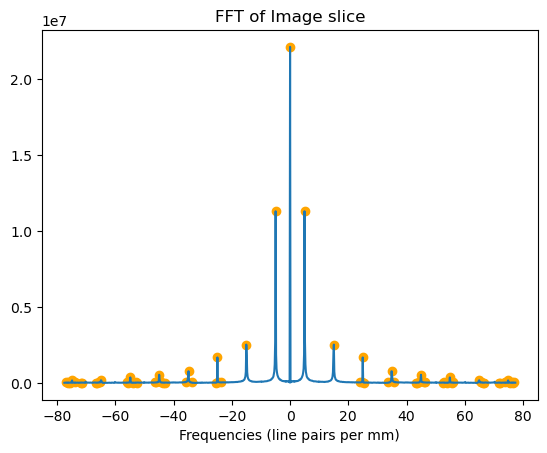

In [221]:
fft_arr = np.abs(fftshift(fft(line)))
fft_arr_freqs = fftshift(fftfreq(len(line), d=length_per_pixel))

peaks, _ = sp.signal.find_peaks(fft_arr, height=0.001*np.max(fft_arr))
peaks = peaks[find_matches(fft_arr_freqs[peaks]/base_frequency, harmonics, 0.04)]
# plt.scatter(fft_arr_freqs[peaks], fft_arr[peaks]/offset_height)
print('Are the correct number of peaks picked out?', len(peaks) == len(harmonics)*2-1)
plot_slice_with_peaks(fft_arr_freqs, fft_arr, peaks)
plt.title('FFT of Image slice')

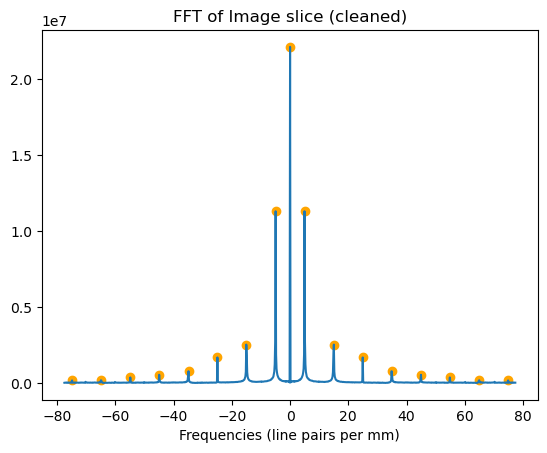

In [222]:
def filter_matches(input, match, rtol, height, return_valid_harmonics=False):
    """ Inputs and height are paired values. 
        For each value of match and for each value of input that is close enough to match,
            use choose the value of input that has the tallest height.
        Returns: 
            np.array of indices that have fulfilled the selection criteria
    """
    valid_indexes = []
    valid_harmonics = []
    # Iterate over target values
    for num in match:
        tallest_value = 0
        tallest_idx = 0
        # Iterate over input array
        for idx, input_value in enumerate(input):
            if np.isclose(input_value, num, rtol=rtol):
                # Check heights only if the input value is close enough to the harmonic
                if height[idx] > tallest_value:
                    tallest_value = height[idx]
                    tallest_idx = idx
        # Do not append if no peak exists for given harmonic
        if tallest_value > 0:
            valid_indexes.append(tallest_idx)
            valid_harmonics.append(num)

    if return_valid_harmonics:
        return np.array(valid_indexes), valid_harmonics
    else:
        return np.array(valid_indexes)
    

pos_neg_harmonics = np.append(-np.arange(1, x_freqs[-1]/base_frequency, 2, dtype=int)[::-1], harmonics) 

peaks = peaks[filter_matches(fft_arr_freqs[peaks]/base_frequency, pos_neg_harmonics, 0.04, fft_arr[peaks])]
plot_slice_with_peaks(fft_arr_freqs, fft_arr, peaks)
plt.title('FFT of Image slice (cleaned)')

positive_peak_values = (fft_arr[peaks]/offset_height)[-len(harmonics):]

In [223]:
positive_peak_values

array([0.99977425, 0.51074302, 0.11406632, 0.07586095, 0.03478762,
       0.02421592, 0.0163354 , 0.00797657, 0.00750005])

## MTF Extraction

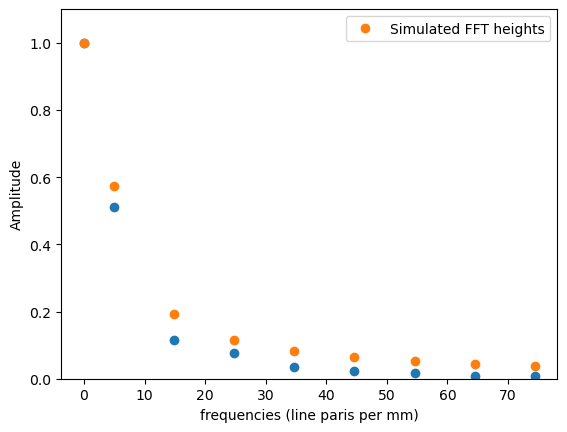

In [224]:
plt.errorbar(harmonics*base_frequency, positive_peak_values  , marker = 'o', ls='')
plt.errorbar(harmonics*base_frequency, df['simulated_fft_height'] , marker = 'o', ls='', label='Simulated FFT heights')

plt.xlabel('frequencies (line paris per mm)')
plt.ylabel('Amplitude')
# plt.xlim(-2,40)
plt.ylim(0,1.1)
plt.legend()

(0.0, 1.1)

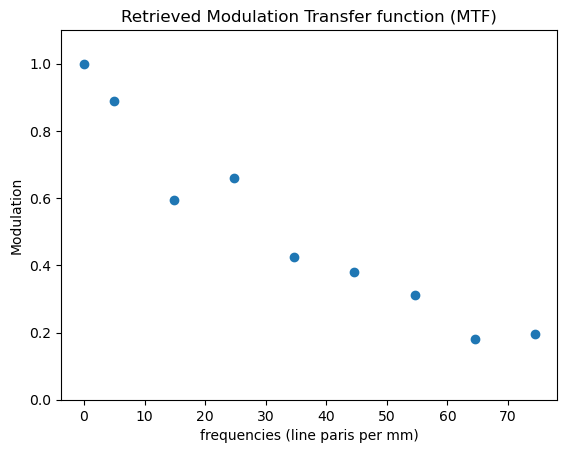

In [225]:
# plt.plot(harmonics*base_frequency, new_peaks / df['simulated_fft_height'])
# plt.scatter()
plt.errorbar(harmonics*base_frequency, positive_peak_values / df['simulated_fft_height'], marker = 'o', ls='', yerr=0.01*positive_peak_values/df['simulated_fft_height'])
plt.xlabel('frequencies (line paris per mm)')
plt.ylabel('Modulation')
plt.title('Retrieved Modulation Transfer function (MTF)')
plt.ylim(0,1.1)

This is the maximum harmonic the system (grating and optics) can capture.

In [226]:
2*e/m

0.0129

In [227]:
x_freqs[-1]/base_frequency

15.59375

## Extension to other slices

Now we just need to perform the same analysis for the rest of the slices. With a couple of caveats.
* We do not need to generate another simulated Ronchi grating, as we want to compare everything to the in focus one. 


Helper functions for plotting.

In [228]:
def plot_line_and_fft(line):
    # Plots line superimposed with ideal grating in focus, derived previously
    
    fig, ax = plt.subplots(1,2, figsize=(10,4))

    # Apply cropping
    t = np.arange(0, len(line))
    offset = np.average(line)

    # Plot length domain
    ax[0].plot(t*length_per_pixel, wave)
    ax[0].plot(t*length_per_pixel, line)
    ax[0].set_ylabel('Magnitude')
    ax[0].set_xlabel('Coordinate (mm)')
    ax[0].set_xlim(4,5)

    ax[1].plot(new_sample_freq, np.abs(wave_fft))
    ax[1].plot(fftshift(fftfreq(len(wave), d = length_per_pixel)), np.abs(fftshift(fft(line))), label='data')
    ax[1].set_xlim(x_freqs[0], x_freqs[-1])
    ax[1].legend()
    ax[1].set_xlabel('Frequencies (line pairs per mm)')
    plt.show()

def plot_line(line):
    plt.figure(figsize=(10,4))
    t = np.arange(0, len(line)) * length_per_pixel
    plt.xlabel('Vertical coordinate (mm)')
    plt.ylabel('Magnitude')
    plt.plot(t, line, color='tab:orange')
    plt.show()


In [229]:
def extract_peaks(idx, debug=False):
    crop_start = 200
    crop_stop = 1200
    column = 500
    peaks_threshold = 0.001

    # Select image slice
    new_im = im_stack[idx]
    line = new_im[crop_start:crop_stop,column]
    if debug: 
        plot_line(line)

    # Take FFT and obtain central slice
    fft_arr = np.abs(fftshift(fft(line)))
    fft_arr_freqs = fftshift(fftfreq(len(line), d=length_per_pixel))
    if debug:
        plot_line_and_fft(line)

    # Extract peaks
    peaks, _ = sp.signal.find_peaks(fft_arr, height=peaks_threshold*np.max(fft_arr))
    peaks = peaks[find_matches(fft_arr_freqs[peaks]/base_frequency, harmonics, 0.04)]
    if debug:
        print('Are the correct number of peaks picked out?', len(peaks) == len(harmonics)*2-1)
        plot_slice_with_peaks(fft_arr_freqs, fft_arr, peaks)
        plt.title('FFT of Image slice')
        plt.show()
    # Clean peaks
    filtered_matches, valid_harmonics = filter_matches(fft_arr_freqs[peaks]/base_frequency, pos_neg_harmonics, 0.04, fft_arr[peaks], True)
    peaks = peaks[filtered_matches]
    if debug:
        plot_slice_with_peaks(fft_arr_freqs, fft_arr, peaks)
        plt.title('FFT of Image slice (cleaned)')
        plt.show()

    # Select positive peak values 
    positive_peak_values = (fft_arr[peaks]/offset_height)[len(valid_harmonics)//2:]
    positive_valid_harmonics = valid_harmonics[len(valid_harmonics)//2:]
    
    return positive_peak_values, positive_valid_harmonics

In [230]:
output = np.zeros((25, len(harmonics)))
for i in range(25):
    peaks_0,_ = extract_peaks(i)
    output[i] = np.pad(peaks_0, (0,len(harmonics) - len(peaks_0)))

In [231]:
lengths = np.arange(10,16.25, 0.25) - 13

In [232]:
lengths

array([-3.  , -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  ,
       -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,
        1.5 ,  1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ])

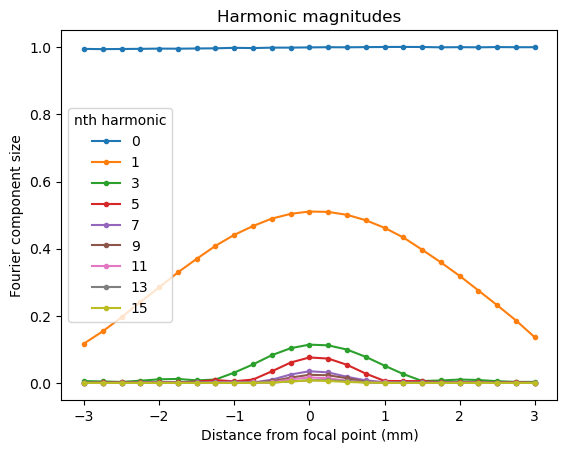

In [233]:
for i in range(output.shape[1]):
    plt.plot(lengths, output[:,i], label=harmonics[i], marker='.')
plt.xlabel('Distance from focal point (mm)')
plt.ylabel('Fourier component size')
plt.title('Harmonic magnitudes')
# plt.ylim(0,1)
plt.legend(title="nth harmonic")

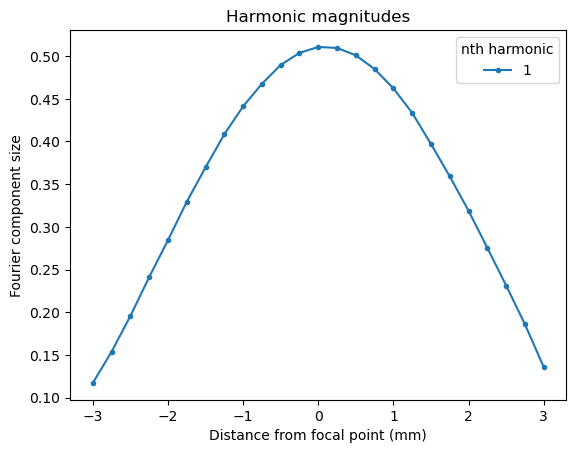

In [234]:
plt.plot(lengths, output[:,1], label=harmonics[1], marker='.')
plt.xlabel('Distance from focal point (mm)')
plt.ylabel('Fourier component size')
plt.title('Harmonic magnitudes')
# plt.ylim(0,1)
plt.legend(title="nth harmonic")

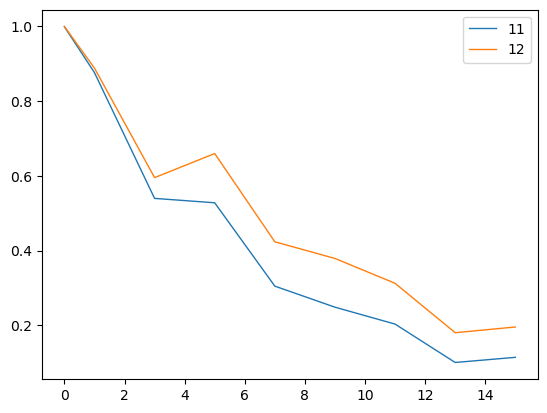

In [235]:
mtf_stack = output/np.array(df['simulated_fft_height'])
for i in [11,12]:
    plt.plot(harmonics, mtf_stack[i], lw=1,  label=i)

plt.legend()

In [238]:
import pickle 
pickle.dump({'lengths':lengths, 'output':output, 'harmonics':harmonics}, open('grating_f_c.pkl', 'wb'))

In [237]:
# pickle.dump(df['simulated_fft_height'], open('simulated_fft_height.pkl', 'wb'))